#DATASCI W261, Machine Learning at Scale
--------
####Assignement:  week \#13
####[Lei Yang](mailto:leiyang@berkeley.edu) | [Michael Kennedy](mailto:mkennedy@ischool.berkeley.edu) | [Natarajan Krishnaswami](mailto:natarajan@krishnaswami.org)
####Due: 2016-04-29, 8AM PST

### Start Spark

In [1]:
import os
import sys
spark_home = os.environ['SPARK_HOME'] = '/Users/leiyang/Downloads/spark-1.6.1-bin-hadoop2.6/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.1
      /_/

Using Python version 2.7.9 (default, Dec 15 2014 10:37:34)
SparkContext available as sc, HiveContext available as sqlContext.


###HW 13.1: Spark implementation of basic PageRank

Write a basic Spark implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input.
Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]

In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016

Run this experiment locally first. Report the local configuration that you used and how long in minutes and seconds it takes to complete your job.

Repeat this experiment on AWS. Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. (in your notebook, cat the cluster config file)



###PageRank

In [1]:
from time import time
from datetime import datetime

def initialize(line):
    # parse line
    nid, adj = line.strip().split('\t', 1)
    exec 'adj = %s' %adj
    # initialize node struct
    node = {'a':adj.keys(), 'p':0}
    rankMass = 1.0/len(adj)
    # emit pageRank mass and node
    return [(m, rankMass) for m in node['a']] + [(nid.strip('"'), node)]

def accumulateMass(a, b):
    if isinstance(a, float) and isinstance(b, float):
        return a+b
    if isinstance(a, float) and not isinstance(b, float):
        b['p'] += a
        return b
    else:
        a['p'] += b
        return a

def getDangling(node):
    global nDangling
    if isinstance(node[1], float):
        nDangling += 1
        return (node[0], {'a':[], 'p':node[1]})
    else:
        return node

def redistributeMass(node):
    node[1]['p'] = (p_dangling.value+node[1]['p'])*damping + alpha
    return node

def distributeMass(node):
    global lossMass
    mass, adj = node[1]['p'], node[1]['a']
    node[1]['p'] = 0
    if len(adj) == 0:
        lossMass += mass
        return [node]
    else:
        rankMass = mass/len(adj)
        return [(x, rankMass) for x in adj]+[node]

def getIndex(line):
    elem = line.strip().split('\t')
    return (elem[1], elem[0])

def logTime():
    return str(datetime.now())


### Driver

In [4]:
from operator import add

# load the graph
graph_file = sc.textFile('hdfs://localhost:9000/user/leiyang/PageRank-test.txt')
index_file = sc.textFile('file:///Users/leiyang/Downloads/toy_index.txt')

# initialize variables
nDangling = sc.accumulator(0)
lossMass = sc.accumulator(0.0)
damping = 0.85
alpha = 1 - damping
nTop, nIter = 100, 10
start = time()
print '%s: start PageRank initialization ...' %(logTime())
graph = graph_file.flatMap(initialize).reduceByKey(accumulateMass).map(getDangling).cache()
# get graph size
G = graph.count()
# broadcast dangling mass for redistribution
p_dangling = sc.broadcast(1.0*nDangling.value/G)
graph = graph.map(redistributeMass)
print '%s: initialization completed, dangling node(s): %d, total nodes: %d' %(logTime(), nDangling.value, G)

for i in range(nIter-1):
    print '%s: running iteration %d ...' %(logTime(), i+2)
    lossMass.value = 0.0
    graph = graph.flatMap(distributeMass).reduceByKey(accumulateMass).cache() #checkpoint()?
    # need to call an action here in order to have loss mass
    graph.count()
    print '%s: redistributing loss mass: %.4f' %(logTime(), lossMass.value)
    p_dangling = sc.broadcast(lossMass.value/G)
    graph = graph.map(redistributeMass)

totalMass = graph.aggregate(0, (lambda x, y: y[1]['p'] + x), (lambda x, y: x+y))
print '%s: normalized weight of the graph: %.4f' %(logTime(), totalMass/G)
print '%s: PageRanking completed in %.2f minutes.' %(logTime(), (time()-start)/60.0)
# get the page name by join
topPages = graph.map(lambda n:(n[0],n[1]['p']/G)).sortBy(lambda n: n[1], ascending=False).take(nTop)
rankList = index_file.map(getIndex).join(sc.parallelize(topPages)).map(lambda l: l[1])
# save final rank list
rankList.sortBy(lambda n: n[1], ascending=False).saveAsTextFile('pageRank')
print '%s: results saved, job completed!' %logTime()


2016-04-15 22:52:21.595538: start PageRank initialization ...
2016-04-15 22:52:22.789142: initialization completed, dangling node(s): 1, total nodes: 11
2016-04-15 22:52:22.789784: running iteration 2 ...
2016-04-15 22:52:22.893942: redistributing loss mass: 0.6523
2016-04-15 22:52:22.900249: running iteration 3 ...
2016-04-15 22:52:23.016227: redistributing loss mass: 0.4174
2016-04-15 22:52:23.021943: running iteration 4 ...
2016-04-15 22:52:23.103576: redistributing loss mass: 0.7042
2016-04-15 22:52:23.108007: running iteration 5 ...
2016-04-15 22:52:23.193200: redistributing loss mass: 0.4136
2016-04-15 22:52:23.197213: running iteration 6 ...
2016-04-15 22:52:23.274630: redistributing loss mass: 0.4254
2016-04-15 22:52:23.278632: running iteration 7 ...
2016-04-15 22:52:23.352806: redistributing loss mass: 0.3753
2016-04-15 22:52:23.356641: running iteration 8 ...
2016-04-15 22:52:23.430620: redistributing loss mass: 0.3812
2016-04-15 22:52:23.434674: running iteration 9 ...
2016

In [5]:
!cat pageRank/part*

(u"'Node_b", 0.3632359489889102)
(u"'Node_c", 0.36288372803871793)
(u"'Node_e", 0.08114525762548769)
(u"'Node_d", 0.03938466342002967)
(u"'Node_f", 0.03938466342002967)
(u"'Node_a", 0.03293010178620472)
(u"'Node_h", 0.016207127344124005)
(u"'Node_j", 0.016207127344124005)
(u"'Node_g", 0.016207127344124005)
(u"'Node_i", 0.016207127344124005)
(u"'Node_k", 0.016207127344124005)


###HW 13.2: Applying PageRank to the Wikipedia hyperlinks network

Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job.

NOTE: ====  English Wikipedia hyperlink network.data ====
The dataset is available via Dropbox at:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

on S3 at  s3://ucb-mids-mls-networks/wikipedia/
-- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt # Graph
-- s3://ucb-mids-mls-networks/wikipedia/indices.txt               # Page titles and page Ids

The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.


###Submit job to the cluster
- ssh i the master node of EMR cluster
- do data preparation
- submit job to spark
- **Note: summary of time, and discussion are presented after the GraphX results in next problem**

###Cluster configuration: 1 m1.large master node + 9 m1.large task nodes

In [ ]:
/usr/bin/spark-submit \
--master yarn \
--deploy-mode client \
--name LeiPageRankToy \
--py-files PageRank.py \
--executor-memory '4600m' \
--executor-cores 2 \
--driver-memory '4600m' \
--num-executors 11 \
PageRankDriver.py > wiki_10_log

###10 Iterations [log](https://raw.githubusercontent.com/leiyang-mids/MIDS/master/W261/HW13-Questions/spark_log_10_iterations)
- execution time: 29.62 minutes

In [1]:
!cat pageRank_time_10_iterations

2016-04-22 21:47:50.407410: start PageRank initialization ...
2016-04-22 21:51:14.131401: initialization completed, dangling node(s): 9410987, total nodes: 15192277
2016-04-22 21:51:14.131474: running iteration 2 ...
2016-04-22 21:54:16.556416: redistributing loss mass: 7608969.0130
2016-04-22 21:54:16.564424: running iteration 3 ...
2016-04-22 21:57:10.348773: redistributing loss mass: 7103036.3037
2016-04-22 21:57:10.356219: running iteration 4 ...
2016-04-22 21:59:57.663450: redistributing loss mass: 6940792.1449
2016-04-22 21:59:57.720320: running iteration 5 ...
2016-04-22 22:02:49.159656: redistributing loss mass: 6884560.5231
2016-04-22 22:02:49.166445: running iteration 6 ...
2016-04-22 22:05:39.179975: redistributing loss mass: 6863177.9617
2016-04-22 22:05:39.186458: running iteration 7 ...
2016-04-22 22:08:22.604490: redistributing loss mass: 6854533.8830
2016-04-22 22:08:22.610610: running iteration 8 ...
2016-04-22 22:11:08.030830: redistributing loss mass: 6850834.1086
20

###50 Iterations [log](https://raw.githubusercontent.com/leiyang-mids/MIDS/master/W261/HW13-Questions/spark_log_50_iterations)
- execution time: 141.40 minutes

In [2]:
!cat pageRank_time_50_iterations

[hadoop@ip-172-31-9-186 lei]$ cat wiki_50_log
2016-04-22 22:27:22.269262: start PageRank initialization ...
2016-04-22 22:30:40.932047: initialization completed, dangling node(s): 9410987, total nodes: 15192277
2016-04-22 22:30:40.932248: running iteration 2 ...
2016-04-22 22:33:38.183716: redistributing loss mass: 7608969.0130
2016-04-22 22:33:38.191269: running iteration 3 ...
2016-04-22 22:36:25.688220: redistributing loss mass: 7103036.3037
2016-04-22 22:36:25.695027: running iteration 4 ...
2016-04-22 22:39:13.888332: redistributing loss mass: 6940792.1449
2016-04-22 22:39:13.895518: running iteration 5 ...
2016-04-22 22:42:05.660363: redistributing loss mass: 6884560.5231
2016-04-22 22:42:05.667313: running iteration 6 ...
2016-04-22 22:44:48.044150: redistributing loss mass: 6863177.9617
2016-04-22 22:44:48.050751: running iteration 7 ...
2016-04-22 22:47:42.365782: redistributing loss mass: 6854533.8830
2016-04-22 22:47:42.372406: running iteration 8 ...
2016-04-22 22:50:25.247

###Top 100 nodes and rank
- 98% pages are in the same order except two has swapped place, but the difference of ranking score is small
- the procedure is actually converging pretty well after 10 iteratins, more iterations won not improve ranking much
- and the plot below show ranking from both execution are very close

**Order**|**Name**|**Rank (Iter=10)**|**Name**|**Rank (Iter=50)**|*Equal?*
:---:|---|---:|---|---:|:---:
1|United States|0.001461|United States|0.001462|Y
2|Animal|0.000666|Animal|0.000666|Y
3|France|0.000640|France|0.000640|Y
4|Germany|0.000575|Germany|0.000575|Y
5|Arthropod|0.000450|Arthropod|0.000450|Y
6|Canada|0.000447|Canada|0.000447|Y
7|Insect|0.000445|Insect|0.000445|Y
8|List of sovereign states|0.000444|List of sovereign states|0.000444|Y
9|United Kingdom|0.000433|United Kingdom|0.000433|Y
10|India|0.000428|India|0.000428|Y
11|England|0.000423|England|0.000423|Y
12|Iran|0.000398|Iran|0.000398|Y
13|World War II|0.000385|World War II|0.000385|Y
14|Poland|0.000363|Poland|0.000363|Y
15|village|0.000344|village|0.000344|Y
16|Countries of the world|0.000338|Countries of the world|0.000338|Y
17|Japan|0.000329|Japan|0.000329|Y
18|Italy|0.000329|Italy|0.000329|Y
19|List of countries|0.000326|List of countries|0.000326|Y
20|Australia|0.000325|Australia|0.000325|Y
21|Voivodeships of Poland|0.000313|Voivodeships of Poland|0.000313|Y
22|National Register of Historic Places|0.000310|National Register of Historic Places|0.000310|Y
23|Lepidoptera|0.000308|Lepidoptera|0.000308|Y
24|Powiat|0.000304|Powiat|0.000303|Y
25|Gmina|0.000298|Gmina|0.000298|Y
26|The New York Times|0.000286|The New York Times|0.000286|Y
27|London|0.000283|London|0.000284|Y
28|English language|0.000269|English language|0.000269|Y
29|China|0.000264|China|0.000264|Y
30|Russia|0.000261|Russia|0.000261|Y
31|New York City|0.000258|New York City|0.000258|Y
32|Departments of France|0.000255|Departments of France|0.000255|Y
33|Spain|0.000251|Spain|0.000251|Y
34|Communes of France|0.000249|Communes of France|0.000249|Y
35|moth|0.000245|moth|0.000245|Y
36|Brazil|0.000245|Brazil|0.000245|Y
37|Association football|0.000239|Association football|0.000239|Y
38|association football|0.000233|association football|0.000233|Y
39|California|0.000221|California|0.000221|Y
40|Counties of Iran|0.000215|Counties of Iran|0.000215|Y
41|Provinces of Iran|0.000215|Provinces of Iran|0.000215|Y
42|Central European Time|0.000211|Central European Time|0.000211|Y
43|Romania|0.000211|Romania|0.000211|Y
44|Bakhsh|0.000207|Bakhsh|0.000207|Y
45|Sweden|0.000203|Sweden|0.000203|Y
46|Rural Districts of Iran|0.000203|Rural Districts of Iran|0.000203|Y
47|Netherlands|0.000197|Netherlands|0.000197|Y
48|Private Use Areas|0.000191|Private Use Areas|0.000191|Y
49|World War I|0.000191|World War I|0.000191|Y
50|Central European Summer Time|0.000188|New York|0.000188|**N**
51|New York|0.000188|Central European Summer Time|0.000188|**N**
52|Mexico|0.000187|Mexico|0.000187|Y
53|Iran Standard Time|0.000187|Iran Standard Time|0.000187|Y
54|AllMusic|0.000185|AllMusic|0.000185|Y
55|Iran Daylight Time|0.000179|Iran Daylight Time|0.000179|Y
56|Hangul|0.000178|Hangul|0.000178|Y
57|Scotland|0.000173|Scotland|0.000173|Y
58|gene|0.000170|gene|0.000169|Y
59|Soviet Union|0.000168|Soviet Union|0.000168|Y
60|Norway|0.000167|Norway|0.000167|Y
61|Allmusic|0.000165|Allmusic|0.000165|Y
62|Paris|0.000161|Paris|0.000161|Y
63|New Zealand|0.000161|New Zealand|0.000161|Y
64|Turkey|0.000159|Turkey|0.000159|Y
65|Plant|0.000158|Plant|0.000158|Y
66|Geographic Names Information System|0.000155|Geographic Names Information System|0.000155|Y
67|Switzerland|0.000155|Switzerland|0.000155|Y
68|Los Angeles|0.000153|Los Angeles|0.000153|Y
69|Romanize|0.000149|Romanize|0.000149|Y
70|United States Census Bureau|0.000148|United States Census Bureau|0.000148|Y
71|Europe|0.000147|Europe|0.000147|Y
72|Angiosperms|0.000142|Angiosperms|0.000142|Y
73|South Africa|0.000141|South Africa|0.000141|Y
74|census|0.000139|census|0.000139|Y
75|Flowering plant|0.000138|Flowering plant|0.000138|Y
76|Austria|0.000136|Austria|0.000136|Y
77|protein|0.000135|protein|0.000135|Y
78|U.S. state|0.000135|U.S. state|0.000135|Y
79|Argentina|0.000131|Argentina|0.000131|Y
80|Political divisions of the United States|0.000130|Political divisions of the United States|0.000130|Y
81|population density|0.000130|population density|0.000130|Y
82|Catholic Church|0.000128|Catholic Church|0.000128|Y
83|Chordate|0.000128|Chordate|0.000128|Y
84|BBC|0.000127|BBC|0.000127|Y
85|Belgium|0.000127|Belgium|0.000127|Y
86|Chicago|0.000124|Chicago|0.000124|Y
87|Washington D.C.|0.000121|Washington D.C.|0.000121|Y
88|Pakistan|0.000120|Pakistan|0.000120|Y
89|Finland|0.000116|Finland|0.000116|Y
90|The Guardian|0.000114|The Guardian|0.000115|Y
91|Latin|0.000114|Latin|0.000114|Y
92|Ontario|0.000114|Ontario|0.000114|Y
93|Czech Republic|0.000114|Czech Republic|0.000114|Y
94|Philippines|0.000113|Philippines|0.000113|Y
95|Denmark|0.000113|Denmark|0.000113|Y
96|Greece|0.000113|Greece|0.000113|Y
97|genus|0.000113|genus|0.000113|Y
98|football (soccer)|0.000112|football (soccer)|0.000112|Y
99|Hungary|0.000112|Hungary|0.000112|Y
100|Eastern European Time|0.000112|Eastern European Time|0.000112|Y

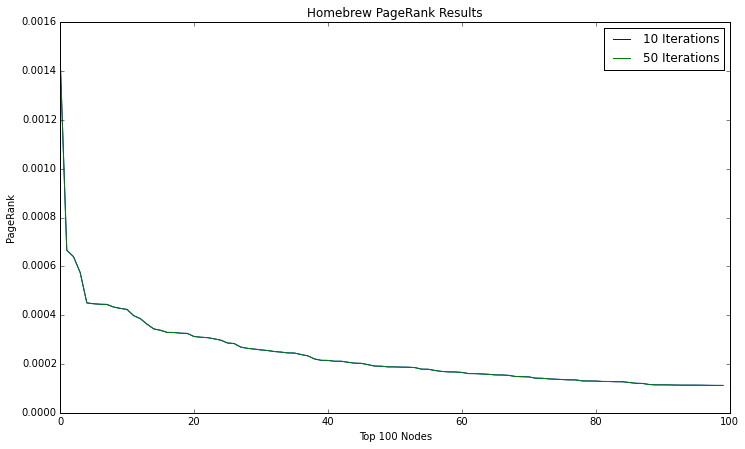

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

with open('PlotPageRank0', 'r') as f:
    header = f.readline()
    ranks = [map(float, l.strip().split('\t')) for l in f.readlines()]

plt.figure(figsize=(12,7))
p = plt.plot(ranks)

plt.legend(['10 Iterations', '50 Iterations'])
plt.xlabel('Top 100 Nodes')
plt.ylabel('PageRank')
plt.title('Homebrew PageRank Results')
plt.show()

###HW 13.3: Spark GraphX versus your implementation of PageRank

Run the Spark  GraphX PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.

Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

Put the runtime results of HW13.2 and HW13.3 in a tabular format (with rows corresponding to implemention and columns corresponding to experiment setup (10 iterations, 50 iterations)). Discuss the run times and explaing the differences. 

Plot the pagerank values for the top 100 pages resulting from the 50 iterations run (using GraphX). Then plot the pagerank values for the same 100 pages that resulted from the 50 iterations run of your homegrown pagerank implemnentation.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.


### Scala code

In [ ]:
import org.apache.spark.SparkContext
import org.apache.spark.SparkContext._
import org.apache.spark.SparkConf
import org.apache.spark.graphx._
import org.apache.spark.graphx.lib._


object WikiPageRank {
    
  def main(args: Array[String]) {
    val t0 = System.nanoTime()        
    val conf = new SparkConf().setAppName("WikiPageRank")
    val sc = new SparkContext(conf)
    var nIter = args(0).toInt

    // Create an RDD for the edges and vertices    
    val links = sc.textFile("hdfs:///user/leiyang/all-pages-indexed-out.txt", 80).flatMap(getLinks);
    val pages = sc.textFile("hdfs:///user/leiyang/indices.txt", 16).map(getPages);

    // Build the initial Graph
    val graph = Graph(pages, links);
    // Run pageRank
    val rank = PageRank.run(graph, numIter=nIter).vertices.cache()
    // Normalize the rank score
    val total = rank.map(l=>l._2).sum()
    val tops = rank.sortBy(l=>l._2, ascending=false).take(200).map(l => (l._1, l._2/total))
    val ret = sc.parallelize(tops).join(pages).map(l => (l._2._2._1, l._2._1)).sortBy(l=>l._2, ascending=false).take(200)
    val elapse = (System.nanoTime()-t0)/1000000000.0/60.0
    // Show results
    println("PageRanking finishes in " + elapse + " minutes!")
    println(ret.mkString("\n"))
  }

  def getLinks(line: String): Array[Edge[String]] = {
      val elem = line.split("\t", 2)
      for {n <-  elem(1).stripPrefix("{").split(",")
          // get Edge between id
      }yield Edge(elem(0).toLong, n.split(":")(0).trim().stripPrefix("'").stripSuffix("'").toLong, "")
  }

  def getPages(line: String): (VertexId, (String, String)) = {
      val elem = line.split("\t")
      return (elem(1).toLong, (elem(0), ""))
  }
}


### Submit Job to Spark - 1 m1.xlarge master node + 9 m1.xlarge task nodes
- package job to build jar with sbt
- [10 iteration log](https://raw.githubusercontent.com/leiyang-mids/MIDS/master/W261/HW13-Questions/spark_log_10_iterations_graphX)
- [50 iteration log](https://raw.githubusercontent.com/leiyang-mids/MIDS/master/W261/HW13-Questions/spark_log_50_iterations_graphX)

In [3]:
# 10 iterations
/usr/bin/spark-submit \
--master yarn \
--deploy-mode client \
--class WikiPageRank \
--name "WikiPageRank" \
--executor-memory '4600m' \
--num-executors 11 \
--driver-memory '4600m' \
target/scala-2.10/pagerank-project_2.10-1.0.jar \
10 > wiki_10_log_GraphX

# 50 iterations
/usr/bin/spark-submit \
--master yarn \
--deploy-mode client \
--class WikiPageRank \
--name "WikiPageRank" \
--executor-memory '4600m' \
--num-executors 11 \
--driver-memory '4600m' \
target/scala-2.10/pagerank-project_2.10-1.0.jar \
50 > wiki_50_log_GraphX

###Results

- **E10?** indicates if the name is the same between homebrew code and GraphX after _10_ iteration
- **E50?** indicates if the name is the same between homebrew code and GraphX after _50_ iteration
- **Equal?** indicate if the name is the same between _10_ and _50_ iterations of GraphX results

**Order**|**Name**|**Rank (Iter=10)**|**E10?**||**Name**|**Rank (Iter=50)**|**E50?**||*Equal?*
:---:|---|---:|:---:||---|---:|:---:||:---:
1|United States|0.001456|Y||United States|0.001462|Y||Y
2|Animal|0.000669|Y||Animal|0.000666|Y||Y
3|France|0.000638|Y||France|0.000640|Y||Y
4|Germany|0.000573|Y||Germany|0.000575|Y||Y
5|Arthropod|0.000452|Y||Arthropod|0.000450|Y||Y
6|Insect|0.000447|**N**||Canada|0.000447|Y||**N**
7|Canada|0.000445|**N**||Insect|0.000445|Y||**N**
8|List of sovereign states|0.000444|Y||List of sovereign states|0.000444|Y||Y
9|United Kingdom|0.000430|Y||United Kingdom|0.000433|Y||Y
10|India|0.000427|Y||India|0.000428|Y||Y
11|England|0.000422|Y||England|0.000423|Y||Y
12|Iran|0.000399|Y||Iran|0.000398|Y||Y
13|World War II|0.000383|Y||World War II|0.000385|Y||Y
14|Poland|0.000362|Y||Poland|0.000363|Y||Y
15|village|0.000345|Y||village|0.000344|Y||Y
16|Countries of the world|0.000339|Y||Countries of the world|0.000338|Y||Y
17|Japan|0.000329|Y||Japan|0.000329|Y||Y
18|Italy|0.000328|Y||Italy|0.000329|Y||Y
19|List of countries|0.000327|Y||List of countries|0.000326|Y||Y
20|Australia|0.000324|Y||Australia|0.000325|Y||Y
21|Voivodeships of Poland|0.000314|Y||Voivodeships of Poland|0.000313|Y||Y
22|National Register of Historic Places|0.000310|Y||National Register of Historic Places|0.000310|Y||Y
23|Lepidoptera|0.000309|Y||Lepidoptera|0.000308|Y||Y
24|Powiat|0.000304|Y||Powiat|0.000303|Y||Y
25|Gmina|0.000298|Y||Gmina|0.000298|Y||Y
26|The New York Times|0.000282|Y||The New York Times|0.000286|Y||Y
27|London|0.000282|Y||London|0.000284|Y||Y
28|English language|0.000267|Y||English language|0.000269|Y||Y
29|China|0.000263|Y||China|0.000264|Y||Y
30|Russia|0.000260|Y||Russia|0.000261|Y||Y
31|New York City|0.000255|Y||New York City|0.000258|Y||Y
32|Departments of France|0.000255|Y||Departments of France|0.000255|Y||Y
33|Spain|0.000250|Y||Spain|0.000251|Y||Y
34|Communes of France|0.000249|Y||Communes of France|0.000249|Y||Y
35|moth|0.000247|Y||moth|0.000245|Y||Y
36|Brazil|0.000245|Y||Brazil|0.000245|Y||Y
37|Association football|0.000238|Y||Association football|0.000239|Y||Y
38|association football|0.000233|Y||association football|0.000233|Y||Y
39|California|0.000220|Y||California|0.000221|Y||Y
40|Counties of Iran|0.000216|Y||Counties of Iran|0.000215|Y||Y
41|Provinces of Iran|0.000216|Y||Provinces of Iran|0.000215|Y||Y
42|Romania|0.000211|**N**||Central European Time|0.000211|Y||**N**
43|Central European Time|0.000211|**N**||Romania|0.000211|Y||**N**
44|Bakhsh|0.000208|Y||Bakhsh|0.000207|Y||Y
45|Rural Districts of Iran|0.000204|**N**||Sweden|0.000203|Y||**N**
46|Sweden|0.000203|**N**||Rural Districts of Iran|0.000203|Y||**N**
47|Netherlands|0.000196|Y||Netherlands|0.000197|Y||Y
48|Private Use Areas|0.000192|Y||Private Use Areas|0.000191|Y||Y
49|World War I|0.000189|Y||World War I|0.000191|Y||Y
50|Central European Summer Time|0.000188|Y||New York|0.000188|Y||**N**
51|Iran Standard Time|0.000188|**N**||Central European Summer Time|0.000188|Y||**N**
52|New York|0.000187|**N**||Mexico|0.000187|Y||**N**
53|Mexico|0.000187|**N**||Iran Standard Time|0.000187|Y||**N**
54|AllMusic|0.000185|Y||AllMusic|0.000185|Y||Y
55|Iran Daylight Time|0.000180|Y||Iran Daylight Time|0.000179|Y||Y
56|Hangul|0.000179|Y||Hangul|0.000178|Y||Y
57|Scotland|0.000172|Y||Scotland|0.000173|Y||Y
58|gene|0.000170|Y||gene|0.000169|Y||Y
59|Norway|0.000167|**N**||Soviet Union|0.000168|Y||**N**
60|Soviet Union|0.000166|**N**||Norway|0.000167|Y||**N**
61|Allmusic|0.000166|Y||Allmusic|0.000165|Y||Y
62|New Zealand|0.000160|**N**||Paris|0.000161|Y||**N**
63|Paris|0.000160|**N**||New Zealand|0.000161|Y||**N**
64|Turkey|0.000159|Y||Turkey|0.000159|Y||Y
65|Plant|0.000158|Y||Plant|0.000158|Y||Y
66|Geographic Names Information System|0.000155|Y||Geographic Names Information System|0.000155|Y||Y
67|Switzerland|0.000154|Y||Switzerland|0.000155|Y||Y
68|Los Angeles|0.000152|Y||Los Angeles|0.000153|Y||Y
69|Romanize|0.000150|Y||Romanize|0.000149|Y||Y
70|United States Census Bureau|0.000147|Y||United States Census Bureau|0.000148|Y||Y
71|Europe|0.000146|Y||Europe|0.000147|Y||Y
72|Angiosperms|0.000142|Y||Angiosperms|0.000142|Y||Y
73|South Africa|0.000141|Y||South Africa|0.000141|Y||Y
74|census|0.000139|Y||census|0.000139|Y||Y
75|Flowering plant|0.000138|Y||Flowering plant|0.000138|Y||Y
76|Austria|0.000136|Y||Austria|0.000136|Y||Y
77|protein|0.000136|Y||protein|0.000135|Y||Y
78|U.S. state|0.000134|Y||U.S. state|0.000135|Y||Y
79|Argentina|0.000130|Y||Argentina|0.000131|Y||Y
80|Political divisions of the United States|0.000130|Y||Political divisions of the United States|0.000130|Y||Y
81|population density|0.000130|Y||population density|0.000130|Y||Y
82|Chordate|0.000129|**N**||Catholic Church|0.000128|Y||**N**
83|Catholic Church|0.000127|**N**||Chordate|0.000128|Y||**N**
84|Belgium|0.000126|**N**||BBC|0.000127|Y||**N**
85|BBC|0.000126|**N**||Belgium|0.000127|Y||**N**
86|Chicago|0.000123|Y||Chicago|0.000124|Y||Y
87|Pakistan|0.000120|**N**||Washington D.C.|0.000121|Y||**N**
88|Washington D.C.|0.000119|**N**||Pakistan|0.000120|Y||**N**
89|Finland|0.000115|Y||Finland|0.000116|Y||Y
90|Ontario|0.000114|**N**||The Guardian|0.000115|Y||**N**
91|genus|0.000113|**N**||Latin|0.000114|Y||**N**
92|Czech Republic|0.000113|**N**||Ontario|0.000114|Y||**N**
93|The Guardian|0.000113|**N**||Czech Republic|0.000114|Y||**N**
94|Latin|0.000113|**N**||Philippines|0.000113|Y||**N**
95|Philippines|0.000113|**N**||Denmark|0.000113|Y||**N**
96|Denmark|0.000113|**N**||Greece|0.000113|Y||**N**
97|Greece|0.000113|**N**||genus|0.000113|Y||**N**
98|Eastern European Time|0.000112|**N**||football (soccer)|0.000112|Y||**N**
99|football (soccer)|0.000112|**N**||Hungary|0.000112|Y||**N**
100|species|0.000112|**N**||Eastern European Time|0.000112|Y||**N**

###Execution Time and Discussion
- the homebrew code is able to execute on m1.large instance smoothly, however GraphX constantly running out of memory with m1.large, so we have to beef up the hardware to m1.xlarge
- execution time in minutes:

Iterations|GraphX|Homebrew|X
:---:|---:|--:|:---:
10|6.76|29.62|4.4
50|24.35|141.40|5.8

- results of 10 iterations between homebrew code and GraphX have some discrepancies, but they are mainly between neighbor pages, in addition the difference between the page ranking score is small
- results (order) of 50 iteratios between homebrew code and GraphX are identical. Since our homebrew code has reached this order with just 10 iterations, the convergence is quite satisfying. Given that it's running on an inferior EC2 tier, the homebrew code performance is not too shabby.
- Finally, let's plot the ranking value for the top 100 pages:


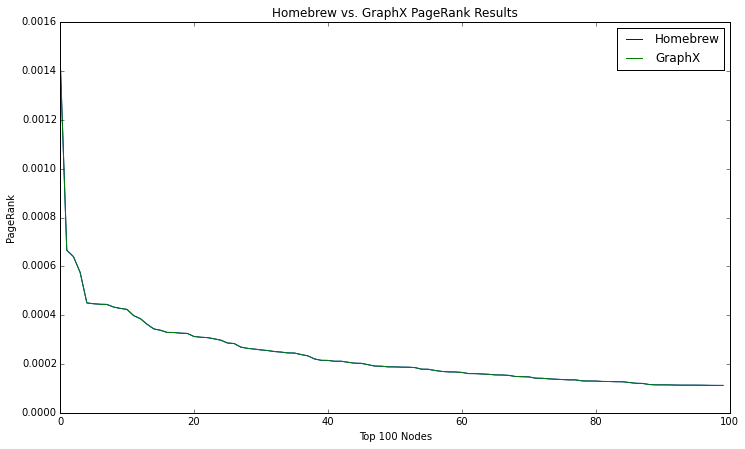

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

with open('PlotPageRank', 'r') as f:
    header = f.readline()
    ranks = [map(float, l.strip().split('\t')) for l in f.readlines()]

plt.figure(figsize=(12,7))
p = plt.plot(ranks)

plt.legend(['Homebrew', 'GraphX'])
plt.xlabel('Top 100 Nodes')
plt.ylabel('PageRank')
plt.title('Homebrew vs. GraphX PageRank Results')
plt.show()

###HW 13.4: Criteo Phase 2 baseline


SPECIAL NOTE:
Please share your findings as they become available with class via the Google Group. You will get brownie points for this.  Once results are shared please use them and build on them.

The Criteo data for this challenge is located in the following S3/Dropbox buckets:

- On Dropbox see:     https://www.dropbox.com/sh/dnevke9vsk6yj3p/AABoP-Kv2SRxuK8j3TtJsSv5a?dl=0

- Raw Data:  (Training, Validation and Test data)
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=rawdata/

- Hashed Data: Training, Validation and Test data in hash encoded (10,000 buckets) and sparse representation
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=processeddata/
- source: https://s3-eu-west-1.amazonaws.com/criteo-labs/dac.tar.gz


Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiment:

- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparamters:

 - Number of buckets for hashing: 1,000
 - Logistic Regression: no regularization term
 - Logistic Regression: step size = 10

- Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

- Report in tabular form the [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) value for the Training, Validation, and Testing datasets.
- Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

- Don't forget to put a caption on your tables (above each table).

###Supporting Functions

In [2]:
%%writefile CriteoHelper2.py

from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector 
from collections import defaultdict
from datetime import datetime
from sklearn import metrics
from math import log, exp
import numpy as np
import hashlib

# hash function
def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

# feature hash
def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """    
    elem = point.strip().split(',')    
    rawFea = [(i, elem[i+1]) for i in range(len(elem) - 1)]
    index = np.sort(hashFunction(numBuckets, rawFea, False).keys())    
    return LabeledPoint(elem[0], SparseVector(numBuckets, index, [1]*len(index)))   

# Logistic Regression Modeling & Evaluation
def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept
    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1/(1+exp(-rawPrediction))


def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12    
    return -log(p+epsilon) if y==1 else -log(1-p+epsilon)

def evaluateResults(lrModel, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """    
    return data.map(lambda p: computeLogLoss(getP(p.features, lrModel.weights, lrModel.intercept), p.label)).mean()

# misc
def logTime(): return str(datetime.now())
def getFP(index): yield max(index)
def getTP(label): yield sum(label)

# calculate AUC score
def getAUCfromRdd(rddData, lrModel):
    labelsAndScores = rddData.map(lambda lp: (lp.label, getP(lp.features, lrModel.weights, lrModel.intercept)))
    if labelsAndScores.getNumPartitions() < 100:   
        labelAndIndex = labelsAndScores.repartition(100).sortBy(lambda (k,v): v, ascending=False).zipWithIndex()
    else:
        labelAndIndex = labelsAndScores.sortBy(lambda (k,v): v, ascending=False).zipWithIndex()
    labelAndIndex.cache()

    truePositives = np.cumsum(labelAndIndex.map(lambda l: l[0][0]).mapPartitions(getTP).collect())
    falsePositives = labelAndIndex.map(lambda l: l[1]+1).mapPartitions(getFP).collect() - truePositives
    numPositive = truePositives[-1]
    length = labelAndIndex.count()

    truePositiveRate = truePositives / numPositive
    falsePositiveRate = falsePositives / (length - numPositive)
    return metrics.auc(falsePositiveRate, truePositiveRate)

def encodeData(sc, numBuckets):
    rawTrainData = sc.textFile('s3://criteo-dataset/rawdata/train/part*', 180).map(lambda x: x.replace('\t', ','))
    rawValidationData = sc.textFile('s3://criteo-dataset/rawdata/validation/part*', 180).map(lambda x: x.replace('\t', ','))
    rawTestData = sc.textFile('s3://criteo-dataset/rawdata/test/part*', 180).map(lambda x: x.replace('\t', ','))

    # data encoding
    hashTrainData = rawTrainData.map(lambda p: parseHashPoint(p, numBuckets))
    hashTrainData.cache()
    hashValidationData = rawValidationData.map(lambda p: parseHashPoint(p, numBuckets))
    hashValidationData.cache()
    hashTestData = rawTestData.map(lambda p: parseHashPoint(p, numBuckets))
    hashTestData.cache()
    
    return hashTrainData, hashValidationData, hashTestData

Overwriting CriteoHelper2.py


###Driver

In [27]:
%%writefile Criteo_Driver_1.py

from time import time, gmtime, strftime

execfile('CriteoHelper2.py')

# define parameters
print '%s: start logistic regression job ...' %(logTime())
numBucketsCTR = 5000
lrStep = 10
start = time()
sc = SparkContext()

# data preparaion
print '%s: preparing data ...' %(logTime())
dTrain, dValidation, dTest = encodeData(numBucketsCTR)

# build model
print '%s: building logistic regression model ...' %(logTime())
model = LogisticRegressionWithSGD.train(dTrain, iterations=500, step=lrStep, regType=None, intercept=True)

# get log loss
print '%s: evaluating log loss ...' %(logTime())
logLossVa = evaluateResults(model, dValidation)
logLossTest = evaluateResults(model, dTest)
logLossTrain = evaluateResults(model, dTrain)

# get AUC
print '%s: evaluating AUC ...' %(logTime())
aucTrain = getAUCfromRdd(dTrain, model)
aucVal = getAUCfromRdd(dValidation, model)
aucTest = getAUCfromRdd(dTest, model)
print '\n%s: job completes in %.2f minutes!' %(logTime(), (time()-start)/60.0)

# show results
print '\n\t\t log loss \t\t\t AUC'
print 'Training:\t %.4f\t\t %.4f' %(logLossTrain, aucTrain)
print 'Validation:\t %.4f\t\t %.4f' %(logLossVa, aucVal)
print 'Test:\t %.4f\t %.4f' %(logLossTest, aucTest)


Overwriting Criteo_Driver_1.py


###Spark Job Results
- cluster: 1 m1.large master node + 9 m1.large task nodes
- execution time: 18.22 minutes
- LogLoss and AUC:

|Log Loss|AUC
:---|---:|---:
Training|0.5042|0.7266
Validation|0.5045|0.7264
Test|0.5044|0.7268

In [29]:
/usr/bin/spark-submit \
--master yarn \
--deploy-mode client \
--name LeiCriteoJob \
--py-files CriteoHelper2.py \
--num-executors 21 \
--executor-memory '4600m' \
--executor-cores 2 \
--driver-memory '4600m' \
Criteo_Driver_1.py > Criteo_log1

2016-04-24 19:16:52.044625: start logistic regression job ...
2016-04-24 19:17:28.296266: preparing data ...
2016-04-24 19:17:29.625300: building logistic regression model ...
2016-04-24 19:34:36.063671: evaluating log loss ...
2016-04-24 19:41:06.268458: evaluating AUC ...

2016-04-24 19:47:16.500257: job completes in 30.41 minutes!

		 log loss 			 AUC
Training:	 0.5042		 0.7266
Validation:	 0.5045		 0.7264
Test:	 0.5044	 0.7268


###HW 13.5: Criteo Phase 2 hyperparameter tuning 
SPECIAL NOTE:
Please share your findings as they become available with class via the Google Group. You will get brownie points for this.  Once results are shared please used them and build on them.

NOTE:  please do  HW 13.5 in groups of 3 

Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:

- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparamters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.
 - Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
 - Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
 - Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially. 

- Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.
- Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
- Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.
- Don't forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

- Discuss the optimal setting to solve this problem  in terms of the following:
 - Features
 - Learning algortihm
 - Spark cluster

Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.



In [6]:
%%writefile Criteo_Driver_2.py

from time import time, gmtime, strftime
from subprocess import call
from pyspark import SparkContext

execfile('CriteoHelper2.py')

# define parameter space
print '%s: start logistic regression job ...' %(logTime())
numBucketsCTR = [1000, 5000, 10000, 20000, 40000]
lrStep = [20, 10, 5, 1]
regParams = [1e-7, 1e-5, 1e-3, 1e-1]
nSteps = len(numBucketsCTR)*len(lrStep)*len(regParams)
print '%s: bucket sizes: %s' %(logTime(), str(numBucketsCTR))
print '%s: LR steps: %s' %(logTime(), str(lrStep))
print '%s: regularization: %s' %(logTime(), str(regParams))
print '%s: total steps: %d' %(logTime(), nSteps)

# initialize 
start = time()
bestModel, bestLogLoss, bestAUC = None, 1e10, 0
sc = SparkContext()

iStep = 1
# grid search
for nBucket in numBucketsCTR:
    # data preparaion    
    dTrain, dValidation, dTest = encodeData(sc, nBucket)
    for stp in lrStep:
        for reg in regParams:
            # build model
            print '%s: step %d/%d starts with bucket-%d, step-%d, reg-%.9f, modeling ...' %(logTime(), iStep, nSteps,
                                                                                            nBucket, stp, reg)
            model = LogisticRegressionWithSGD.train(dTrain, iterations=500, step=stp, 
                                                    regParam=reg, regType='l2', intercept=True)
            # get log loss
            print '%s: evaluating log loss ...' %(logTime())
            logLossVa = evaluateResults(model, dValidation)
            # get AUC
            print '%s: evaluating AUC ...' %(logTime())            
            aucVal = getAUCfromRdd(dValidation, model)
            # compare model
            print '%s: step %d/%d completed, logLoss-%.4f, AUC-%.4f' %(logTime(), iStep, nSteps, logLossVa, aucVal)            
            if logLossVa < bestLogLoss:
                bestLogLoss, bestModel, bestAUC = logLossVa, model, aucVal                
            # save all results to s3, in case job crashes - aws s3 cp toy_index.txt s3://w261.data/HW13/toy.txt
            logName = 's3://w261.data/HW13/criteo_search_log_' + strftime("%d%b%Y_%H%M%S", gmtime())
            call(['aws', 's3', 'cp', '/home/hadoop/lei/criteo_search_log.txt', logName, '--region', 'us-west-2'])
            iStep += 1

# use best model to evaluate 
print '%s: grid search completed in %.2f minutes!' %(logTime(), (time()-start)/60.0)
print '%s: our best model has log loss %.4f and AUC %.4f' %(logTime(), bestLogLoss, bestAUC)

# show results
print '%s: checking log loss for test data ...' %logTime()
logLoss = evaluateResults(bestModel, dTest)
print '%s: checking AUC for test data ...' %logTime()
aucTest = getAUCfromRdd(dTest, bestModel)
print '%s: our best model has log loss %.4f and AUC %.4f on test data.' %(logTime(), logLoss, aucTest)

# save log to s3
print '\n%s: job completes in %.2f minutes!' %(logTime(), (time()-start)/60.0)
logName = 's3://w261.data/HW13/criteo_search_log_' + strftime("%d%b%Y_%H%M%S", gmtime())
call(['aws', 's3', 'cp', '/home/hadoop/lei/criteo_search_log.txt', logName, '--region', 'us-west-2'])

Overwriting Criteo_Driver_2.py


###Spark Job Results
- cluster: 1 m3.xlarge master node + 10 m3.xlarge task nodes
- [job log](https://raw.githubusercontent.com/leiyang-mids/MIDS/master/W261/HW13-Questions/Criteo_grid_search)
- execution time: 300.52 minutes
- best model obtained with 20,000 bucket, 20 steps, and 0.0000001 regularization
- with best model: test data log loss: 0.4879, AUC: 0.7527

In [ ]:
# DO NOT change log file name at the end
# m3.xlarge
/usr/bin/spark-submit \
--master yarn \
--deploy-mode client \
--name LeiCriteoJob \
--py-files CriteoHelper2.py \
--num-executors 20 \
--executor-memory '10280m' \
--executor-cores 4 \
--driver-memory '10280m' \
Criteo_Driver_2.py > criteo_search_log.txt

# r3.xlarge 
/usr/bin/spark-submit \
--master yarn \
--deploy-mode client \
--name LeiCriteoJob \
--py-files CriteoHelper2.py \
--num-executors 20 \
--executor-memory '20000m' \
--executor-cores 4 \
--driver-memory '20000m' \
Criteo_Driver_2.py > criteo_search_log.txt

###Grid Search Summary

Time|Bucket|Step|Reg|Log Loss|AUC
:---|:---:|:---:|---:|---:|---:
2016-04-25 03:16:01|1000|20|0.0000001|0.5031|0.7280
2016-04-25 03:31:14|1000|20|0.00001|0.5031|0.7280
2016-04-25 03:35:59|1000|20|0.001|0.5031|0.7280
2016-04-25 03:40:49|1000|20|0.1|0.5364|0.6930
2016-04-25 03:47:17|1000|10|0.0000001|0.5045|0.7260
2016-04-25 03:50:54|1000|10|0.00001|0.5045|0.7260
2016-04-25 03:54:28|1000|10|0.001|0.5051|0.7250
2016-04-25 03:57:49|1000|10|0.1|0.5364|0.6930
2016-04-25 04:00:29|1000|5|0.0000001|0.5070|0.7220
2016-04-25 04:04:24|1000|5|0.00001|0.5070|0.7220
2016-04-25 04:08:21|1000|5|0.001|0.5075|0.7210
2016-04-25 04:12:12|1000|5|0.1|0.5363|0.6930
2016-04-25 04:13:51|1000|1|0.0000001|0.5192|0.7040
2016-04-25 04:17:51|1000|1|0.00001|0.5192|0.7040
2016-04-25 04:21:52|1000|1|0.001|0.5194|0.7040
2016-04-25 04:25:49|1000|1|0.1|0.5372|0.6900
2016-04-25 22:18:46|5000|20|0.0000001|0.4913|0.7470
2016-04-25 22:34:38|5000|20|0.00001|0.4914|0.7470
2016-04-25 22:39:36|5000|20|0.001|0.4931|0.7440
2016-04-25 22:44:14|5000|20|0.1|0.5353|0.6950
2016-04-25 22:50:29|5000|10|0.0000001|0.4956|0.7400
2016-04-25 22:55:23|5000|10|0.00001|0.4956|0.7400
2016-04-25 23:00:17|5000|10|0.001|0.4972|0.7380
2016-04-25 23:04:49|5000|10|0.1|0.5354|0.6950
2016-04-25 23:07:32|5000|5|0.0000001|0.5006|0.7330
2016-04-25 23:12:29|5000|5|0.00001|0.5006|0.7330
2016-04-25 23:17:28|5000|5|0.001|0.5016|0.7320
2016-04-25 23:22:07|5000|5|0.1|0.5353|0.6950
2016-04-25 23:23:46|5000|1|0.0000001|0.5168|0.7080
2016-04-25 23:28:26|5000|1|0.00001|0.5168|0.7080
2016-04-25 23:32:55|5000|1|0.001|0.5170|0.7080
2016-04-25 23:37:26|5000|1|0.1|0.5362|0.6920
2016-04-25 23:40:34|10000|20|0.0000001|0.4889|0.7500
2016-04-25 23:56:11|10000|20|0.00001|0.4889|0.7500
2016-04-26 00:01:38|10000|20|0.001|0.4913|0.7470
2016-04-26 00:06:38|10000|20|0.1|0.5351|0.6960
2016-04-26 00:13:19|10000|10|0.0000001|0.4940|0.7430
2016-04-26 00:18:42|10000|10|0.00001|0.4940|0.7430
2016-04-26 00:24:11|10000|10|0.001|0.4958|0.7410
2016-04-26 00:28:50|10000|10|0.1|0.5352|0.6960
2016-04-26 03:41:33|10000|5|0.0000001|0.4995|0.7350
2016-04-26 03:57:35|10000|5|0.00001|0.4995|0.7350
2016-04-26 04:03:00|10000|5|0.001|0.5006|0.7330
2016-04-26 04:08:07|10000|5|0.1|0.5351|0.6960
2016-04-26 04:09:49|10000|1|0.0000001|0.5163|0.7090
2016-04-26 04:14:38|10000|1|0.00001|0.5163|0.7090
2016-04-26 04:19:32|10000|1|0.001|0.5166|0.7090
2016-04-26 04:24:23|10000|1|0.1|0.5360|0.6930
2016-04-26 02:00:30|20000|20|0.0000001|**0.4879**|**0.752**
2016-04-26 02:17:10|20000|20|0.00001|0.4879|0.7520
2016-04-26 02:23:14|20000|20|0.001|0.4906|0.7490
2016-04-26 02:28:33|20000|20|0.1|0.5352|0.6960
2016-04-26 02:35:39|20000|10|0.0000001|0.4934|0.7440
2016-04-26 02:41:32|20000|10|0.00001|0.4934|0.7440
2016-04-26 02:47:23|20000|10|0.001|0.4953|0.7420
2016-04-26 02:52:34|20000|10|0.1|0.5352|0.6960
2016-04-26 02:55:27|20000|5|0.0000001|0.4992|0.7350
2016-04-26 03:01:13|20000|5|0.00001|0.4992|0.7350
2016-04-26 03:06:59|20000|5|0.001|0.5003|0.7340
2016-04-26 03:12:20|20000|5|0.1|0.5351|0.6960
2016-04-26 03:14:03|20000|1|0.0000001|0.5163|0.7090
2016-04-26 03:19:12|20000|1|0.00001|0.5163|0.7090
2016-04-26 03:24:32|20000|1|0.001|0.5165|0.7090
2016-04-26 03:29:37|20000|1|0.1|0.5361|0.6930

###Discussion
- we can see larger bucket size yields better results, this indicates that hashing with **small** bucket size will not provide optimal feature. The grid search should continue with bigger bucket size in order to obtain better results.
- as bucket size increases, input dimension also increase, but due to sparcity, the training time of logistic regression doesn't change too much. 
- smaller regularization parameter also give better results, this indicates the convergence process is not so smooth, we need to take baby step in order to avoid slippery slope.
- finally, larger step is better than smaller step, which gives better stochastic gradient descent performance.
- below we show the heatmap of LogLoss for each bucket size:

In [5]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def showHeatMap(stepSizes, regParams, logLoss):
    numRows, numCols = len(stepSizes), len(regParams)
    logLoss = np.array(logLoss)
    logLoss.shape = (numRows, numCols)

    fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7),
                      hideLabels=True, gridWidth=0.)
    ax.set_xticklabels(regParams), ax.set_yticklabels(stepSizes)
    ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Step Size')

    colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
    image = plt.imshow(logLoss,interpolation='nearest', aspect='auto', cmap = colors)
    #pass
    plt.show()

Log Loss, bucket size: 1000


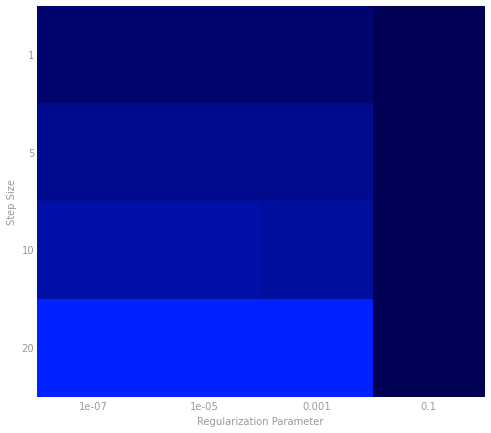

AUC, bucket size: 1000


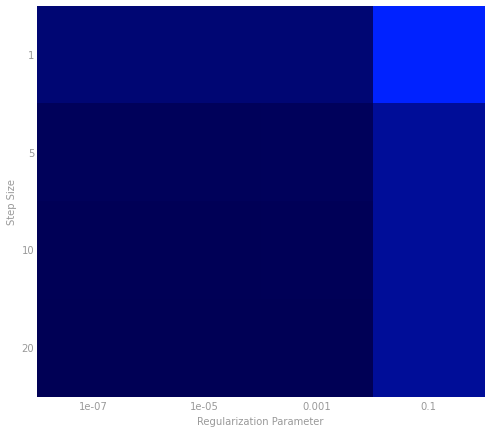

Log Loss, bucket size: 5000


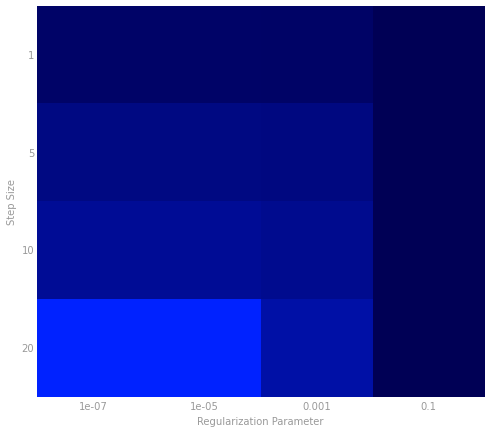

AUC, bucket size: 5000


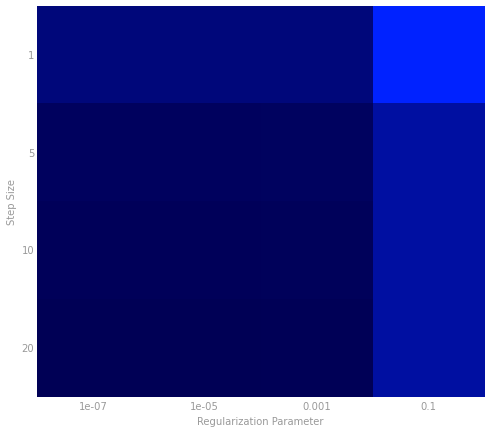

Log Loss, bucket size: 10000


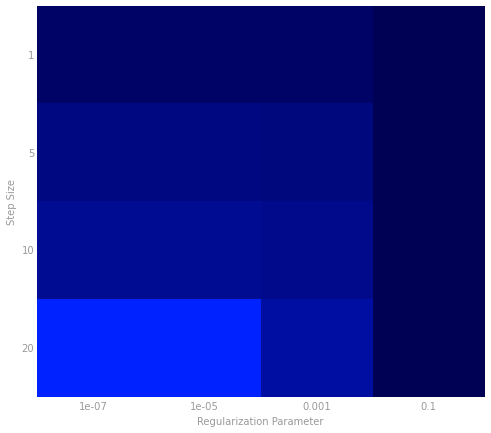

AUC, bucket size: 10000


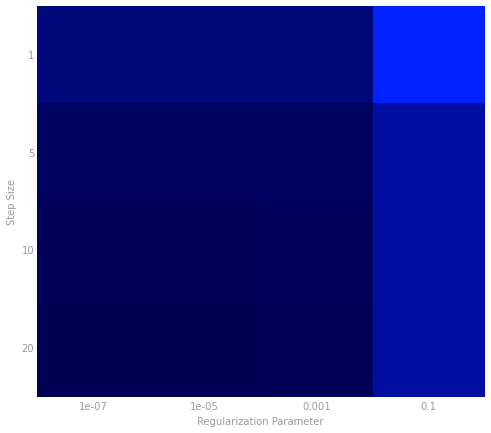

Log Loss, bucket size: 20000


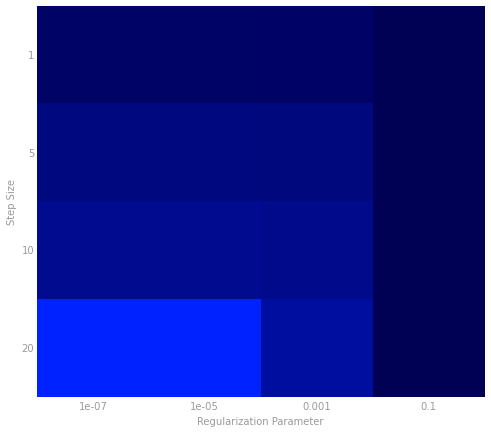

AUC, bucket size: 20000


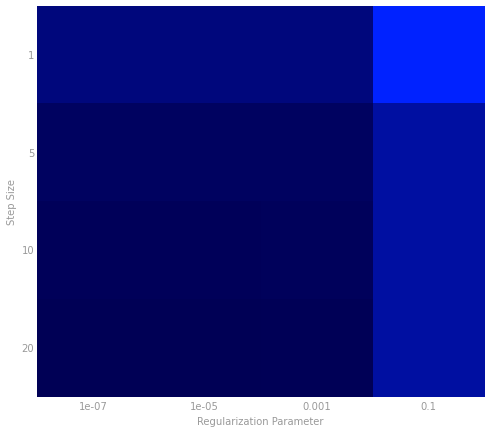

In [8]:
%matplotlib inline
import numpy as np

buckets = [1000, 5000, 10000, 20000]
steps = [1, 5, 10, 20]
regParam = [1e-7, 1e-5, 1e-3, 1e-1]
llMap = {b:np.eye(len(steps)) for b in buckets}
aucMap = {b:np.eye(len(steps)) for b in buckets}

with open('PlotGridSearch', 'r') as f:
    header = f.readline()
    for l in f.readlines():
        ts, bucket, step, reg, ll, auc = l.strip().split('\t')
        llMap[int(bucket)][steps.index(int(step))][regParam.index(float(reg))] = float(ll)
        aucMap[int(bucket)][steps.index(int(step))][regParam.index(float(reg))] = float(auc)

for b in buckets: 
    print 'Log Loss, bucket size: %d' %b
    showHeatMap(steps, regParam, llMap[b])
    print 'AUC, bucket size: %d' %b
    showHeatMap(steps, regParam, aucMap[b])

###HW13.6 Heritage Healthcare Prize (OPTIONAL)

The slides for Week 13 Live session contain background information for the HHH competition to predict the number of days a patient will spend in hospital.  Please review the sldies. All the data, RCode, documentation, and slides for HHH problem are located at: 

https://www.dropbox.com/sh/upt0j2q44ncrn1m/AAApdpXNYaEFy8KbMoE90-KSa?dl=0 

In particular have a look at the following R Code:

https://www.dropbox.com/s/jltk9z7jkc1o856/mainDriver.R?dl=0

This code runs and will produce a baseline submission file for HHH. 

Challenge: 

Rewrite this code in Spark (all steps) and produce a submission file. Report your experimental setup and experimental times.

Improve the predictive quality of your system through activities such as:

-- new features
-- feature transformations
-- data sampling/deletion
-- third party data
-- learning algorithms
-- hyperparameter tuning
-- etc.


State your assumptions (Training data, validation data, held out test data). Report your experimental setup and experimental times, and evaluation metrics versus the baseline submission code provided above and discuss.


###Start HDFS

In [8]:
!/usr/local/Cellar/hadoop/2*/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/start-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ start historyserver 

starting yarn daemons
resourcemanager running as process 17585. Stop it first.
localhost: nodemanager running as process 17686. Stop it first.
Starting namenodes on [localhost]
localhost: starting namenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-namenode-Leis-MacBook-Pro.local.out
localhost: starting datanode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-datanode-Leis-MacBook-Pro.local.out
Starting secondary namenodes [0.0.0.0]
0.0.0.0: starting secondarynamenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-secondarynamenode-Leis-MacBook-Pro.local.out
historyserver running as process 18148. Stop it first.


###Stop HDFS

In [6]:
!/usr/local/Cellar/hadoop/2*/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/stop-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ stop historyserver 
sc.stop()

stopping yarn daemons
no resourcemanager to stop
localhost: no nodemanager to stop
no proxyserver to stop
Stopping namenodes on [localhost]
localhost: no namenode to stop
localhost: no datanode to stop
Stopping secondary namenodes [0.0.0.0]
0.0.0.0: no secondarynamenode to stop
no historyserver to stop
